Extreme Value Analysis (EVA) is a statistical methodology that is used primarily to estimate the probability of events that are rarest compared to any previously observed. The fields of application are generally engineering, meteorology, hydrology, finance, and oceanography. As is, it is an approach that exists from different years and it’s used to deal with the extreme deviations from distributions of reference.


What we can try to do here it’s a step further. We use EVA during the evaluation of our deep-learning model in an application of anomaly detection. We don’t try to reinvent anything, we simply use the Extreme Value Theory to provide an additional explanation of the results of our supervised approach. Our methodology is not algorithm related and can be easily generalized or modified to suit every modeling pipeline.


In this post, we develop a time series forecasting application based on a deep-learning structure. After correctly validating it, we pass to inspect the reliability of predictions with the EVA. We inspect the residuals generated on a selected control period to individuate how ‘extreme’ they are and how ‘frequent’ in the future they can appear. Generate statistics and confidences on these aspects permits us to point out how anomalies, i.e. situations not modeled by our deep-learning framework, can reveal in the future.

In [2]:
import os
import random
import warnings
import numpy as np
from scipy import stats
from fitter import Fitter
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasGridSearch

We use a dataset that comes from the Vancouver Open Data Catalogue. It is easily accessible on Kaggle and reports more than 500M records of crimes registered in the Canadian city from 2003 to 2017. We focus only on the aggregated series of daily crimes. This series appears to be very noisy as shown in the figure below.

In [3]:
### READ DATA ###

df = pd.read_csv('crime.csv.zip')
df['Date'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

df = pd.DataFrame({'n_crimes':df.Date.value_counts().sort_index()})
df['month'] = df.index.month
df['wday'] = df.index.dayofweek
df['day'] = df.index.day

print(df.shape)
df.head()

(5308, 4)


,n_crimes,month,wday,day
2003-01-01,191,1,2,1
2003-01-02,148,1,3,2
2003-01-03,160,1,4,3
2003-01-04,146,1,5,4
2003-01-05,120,1,6,5


Text(0, 0.5, 'daily crimes')

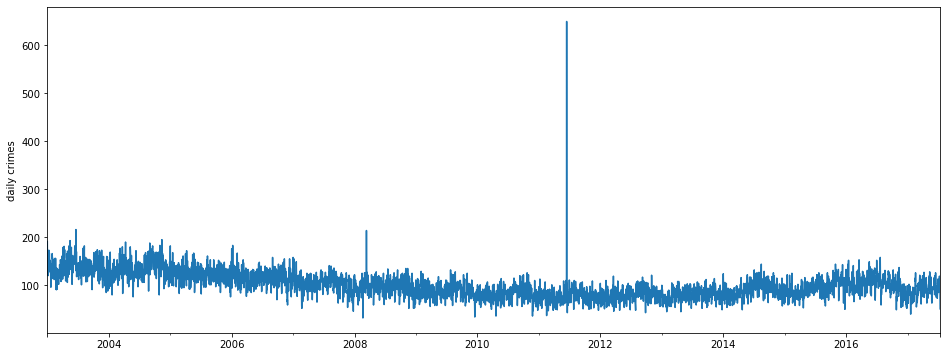

In [4]:
### PLOT AGGREGATED DAILY CRIMES ###

df.n_crimes.plot(figsize=(16,6))
plt.ylabel('daily crimes')

However, some form of seasonalities can be detected in weekly and monthly levels.


Text(0.5, 0, 'weekday')

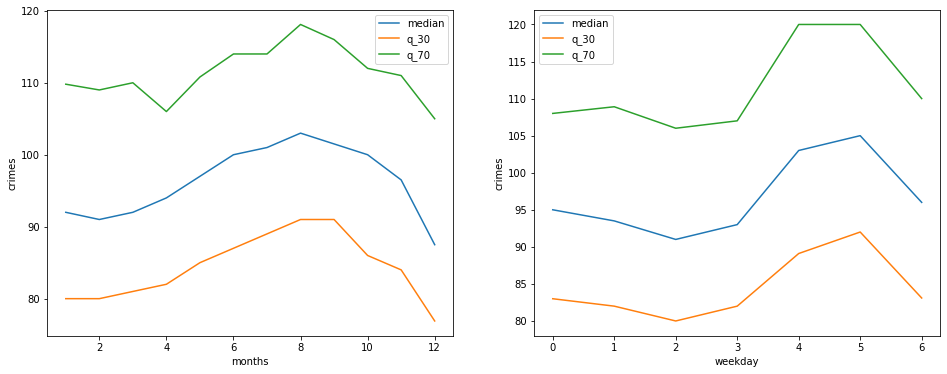

In [5]:
### PLOT SEASONALITY PATTERNS FOR CRIME SERIES ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.n_crimes.groupby(df.index.month).median().rename('median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.month).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('crimes'); plt.xlabel('months')

plt.subplot(122)
df.n_crimes.groupby(df.index.weekday).median().rename('median').plot(ax=plt.gca(), legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.3).rename('q_30').plot(legend=True)
df.n_crimes.groupby(df.index.weekday).apply(np.quantile, 0.7).rename('q_70').plot(legend=True)
plt.ylabel('crimes'); plt.xlabel('weekday')

# THE MODEL
We use this information to build a forecasting model that predicts future crimes in the upcoming days given a past sequence of observations. For this kind of task, we develop a Seq2Seq LSTM autoencoder. Its structure suits well to model the data at our disposal because we can combine the raw time signals with the creation of temporal embeddings. The encoder is feed with sequences of numerical inputs (sequences of target history) plus the numerical embeddings of historical weekdays and months.

The decoder receives the decoder output plus the numerical embeddings of the future weekdays and months to produce 7 days ahead forecast.The training process is computed by optimizing the parameters on the validation set with a grid search approach through keras-hypetune, a simple framework for Keras Hyperparameters Tuning based only on NumPy.

The predictions generated on our validation set are depicted below together with the corresponding performances computed for each future time lag. Our baseline of reference is constituted by a dummy repetition of the last valid observation.


In [6]:
### DEFINE UTILITY FUNCTIONS ###

def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


class Scaler3D:
    
    def fit(self, X):
        self.mean = X.reshape(-1,X.shape[-1]).mean(0).reshape(1,1,-1)
        self.std = X.reshape(-1,X.shape[-1]).std(0).reshape(1,1,-1)
        return self
        
    def transform(self, X):
        return (X - self.mean) / self.std
    
    def inverse_transform(self, X):
        return (X * self.std) + self.mean

    
def prepare_seq(num_X, cat1_X, cat2_X, scaler=None):
    
    if scaler is not None:
        num_X = scaler.transform(num_X)
        
    inp_dict = {}
    inp_dict['inp_num'] = num_X
    for i,c in enumerate(cat_var):
        inp_dict[f"inp_{c}_cat1"] = cat1_X[:,:,i]
        inp_dict[f"inp_{c}_cat2"] = cat2_X[:,:,i]
    
    return inp_dict

In [7]:
### TRAIN VALID SPLIT AND SCALING ###

time_h = 7
window_shape = 21

target = ['n_crimes']
cat_var = ['month','wday','day']

_id_train, _id_valid = train_test_split(np.arange((len(df) - window_shape - time_h + 1)), test_size=0.3, shuffle=False)

_num_X = create_windows(df[target], window_shape=window_shape, end_id=-time_h)
_cat1_X = create_windows(df[cat_var], window_shape=window_shape, end_id=-time_h)
_cat2_X = create_windows(df[cat_var], window_shape=time_h, start_id=window_shape)
_target = create_windows(df[target], window_shape=time_h, start_id=window_shape)

_num_X_train = _num_X[_id_train]; _num_X_valid = _num_X[_id_valid]
_cat1_X_train = _cat1_X[_id_train]; _cat1_X_valid = _cat1_X[_id_valid]
_cat2_X_train = _cat2_X[_id_train]; _cat2_X_valid = _cat2_X[_id_valid]
_target_train = _target[_id_train]; _target_valid = _target[_id_valid]

X_scaler = Scaler3D().fit(_num_X_train)
y_scaler = Scaler3D().fit(_target_train)

X_train = prepare_seq(_num_X_train, _cat1_X_train, _cat2_X_train, scaler=X_scaler)
y_train = y_scaler.transform(_target_train)
X_valid = prepare_seq(_num_X_valid, _cat1_X_valid, _cat2_X_valid, scaler=X_scaler)
y_valid = y_scaler.transform(_target_valid)

In [8]:
### DEFINE MODEL STRUCTURE TO OPTIMIZE ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param):
    
    set_seed(33)
    
    inp_num = Input((window_shape,1), name='inp_num')
    
    embeddings = {
        'month': Embedding(12+1, param['emb_dim']),
        'wday': Embedding(6+1, param['emb_dim']),
        'day': Embedding(31+1, param['emb_dim'])
    }
    
    inp_cat1, emb_cat = [], []
    for c in cat_var:
        _inp_c1 = Input((window_shape,), name=f"inp_{c}_cat1")
        emb = embeddings[c](_inp_c1)
        inp_cat1.append(_inp_c1)
        emb_cat.append(emb)
    
    enc = Concatenate()([inp_num] + emb_cat)
    enc = LSTM(param['lstm_unit'], return_sequences=False)(enc)
    
    inp_cat2, emb_future = [], []
    for c in cat_var:
        _inp_c2 = Input((time_h,), name=f"inp_{c}_cat2")
        emb = embeddings[c](_inp_c2)
        inp_cat2.append(_inp_c2)
        emb_future.append(emb) 
    
    x = RepeatVector(time_h)(enc)
    dec = Concatenate()([x] + emb_future)
    dec = LSTM(param['lstm_unit'], return_sequences=True)(dec)
    
    output = TimeDistributed(Dense(1))(dec)
    
    model = Model([inp_num] + inp_cat1 + inp_cat2, output)
    model.compile(Adam(lr=param['lr']), 'mse')
    
    return model

In [9]:
### FIT AND OPTIMIZE MODEL ###

param_grid = {
    'lstm_unit': [128,64,32], 
    'emb_dim': [8,16,32],
    'lr': [1e-4,1e-3], 
    'epochs': 100, 
    'batch_size': 64
}

es = EarlyStopping(patience=7, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = get_model
kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[es])


18 trials detected for ('lstm_unit', 'emb_dim', 'lr', 'epochs', 'batch_size')


C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(



***** (1/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21963 at epoch 24

***** (2/18) *****
Search({'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.21379 at epoch 16

***** (3/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22076 at epoch 15

***** (4/18) *****
Search({'lstm_unit': 128, 'emb_dim': 16, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22021 at epoch 2

***** (5/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22114 at epoch 15

***** (6/18) *****
Search({'lstm_unit': 128, 'emb_dim': 32, 'lr': 0.001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.22087 at epoch 2

***** (7/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8, 'lr': 0.0001, 'epochs': 100, 'batch_size': 64})
SCORE: 0.2201 at epoch 35

***** (8/18) *****
Search({'lstm_unit': 32, 'emb_dim': 8,

<kerashypetune.KerasGridSearch>

In [10]:
print('BEST PARAM:', kgs.best_params)

BEST PARAM: {'lstm_unit': 128, 'emb_dim': 8, 'lr': 0.001, 'epochs': 16, 'batch_size': 64, 'steps_per_epoch': 58}


In [11]:
### RETRIVE PREDICTIONS ###

pred = np.squeeze(
    y_scaler.inverse_transform(
        kgs.best_model.predict(X_valid)
    ), -1)

y_valid = np.squeeze(y_scaler.inverse_transform(y_valid), -1)

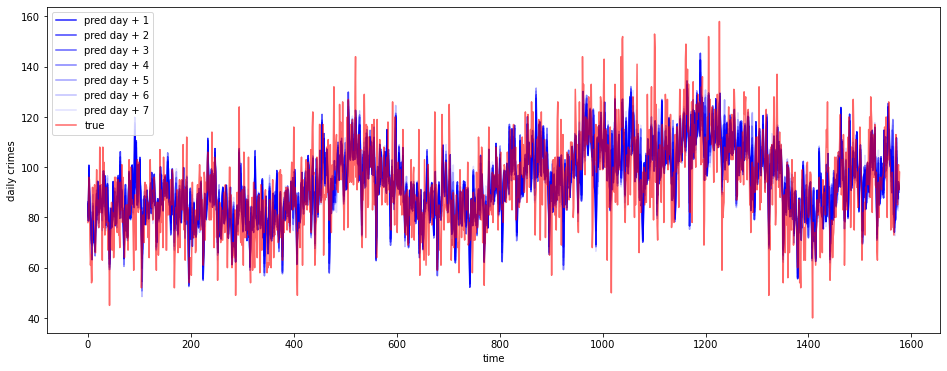

In [12]:
### PLOT TRUE vs PREDICTIONS ###

plt.figure(figsize=(16,6))

for t_h in range(time_h):
    plt.plot(pred[(time_h-t_h):-(t_h+1),t_h], 
             c='blue', alpha=1-1/(time_h+1)*(t_h+1),
             label=f"pred day + {t_h+1}")

plt.plot(y_valid[time_h:,0], c='red', alpha=0.6, label='true')

plt.ylabel('daily crimes'); plt.xlabel('time'); plt.legend(); plt.show()
np.set_printoptions(False)

In [13]:
### GET MODEL AND BASELINE MSE ###

mse_model = {}
mse_baseline = {}
    
for t_h in range(time_h):

    _mse = mse(y_valid[1:,t_h], y_valid[:-1,0])
    mse_baseline[f"day + {t_h+1}"] = _mse 

    _mse = mse(y_valid[:,t_h], pred[:,t_h])
    mse_model[f"day + {t_h+1}"] = _mse 

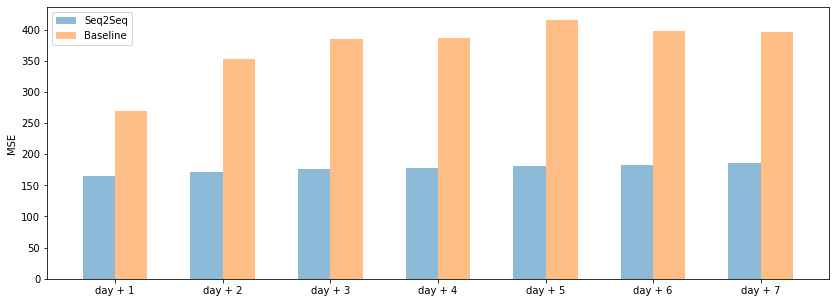

In [14]:
### PLOT AND COMPARE MSE ###

plt.figure(figsize=(14,5))

plt.bar(np.arange(len(mse_model))-0.15, mse_model.values(), alpha=0.5, width=0.3, label='Seq2Seq')
plt.bar(np.arange(len(mse_baseline))+0.15, mse_baseline.values(), alpha=0.5, width=0.3, label='Baseline')
plt.xticks(range(len(mse_baseline)), mse_baseline.keys())
plt.ylabel('MSE'); plt.legend()
np.set_printoptions(False)

# EXTREME VALUE ANALYSIS
At this point, an optimized version of our model is trained and ready to use. What we are trying to do now is to explain the performances applying some techniques typical of the EVA. For our experiment, the term ‘validation set’ is used to define, in a more general way, a ‘control group’, i.e. a time interval used to operate tuning and the application of the EVA.


The first ingredient we are interested in is the residuals generated by our model on the validation set. We consider the absolute values of residuals as extreme values. This choice is reasonable because they represent the unknown situations where our forecasting model registers a lack of performance. In other words, the situations where our model tends to be wrong are not studied yet and so labeled as anomalous events. The degree of the anomaly is measured by the distance from the reality and the prediction. A standard approach of the EVA consists of identifying as anomalous/extreme all the observations upper than a fixed threshold (Peak over Threshold) or construct a sequence of the maxima obtained segregated the original series into blocks (Block Maxima Method). The choice of the method is domain related and can produce different results. For sure deriving the extreme values from the model residuals can give us the confidence to operate with stationary series, which is a prerequisite of the EVA.

In [15]:
### GET RESIDUALS ###

t_h = 1 # desired time forecasting horizon to compute the EVA

resid = np.abs(y_valid[:,t_h] - pred[:,t_h])
data = pd.Series(resid, index=(df.iloc[_id_valid[0]:_id_valid[-1]+1]).index, name='resid')

Text(0, 0.5, 'residuals')

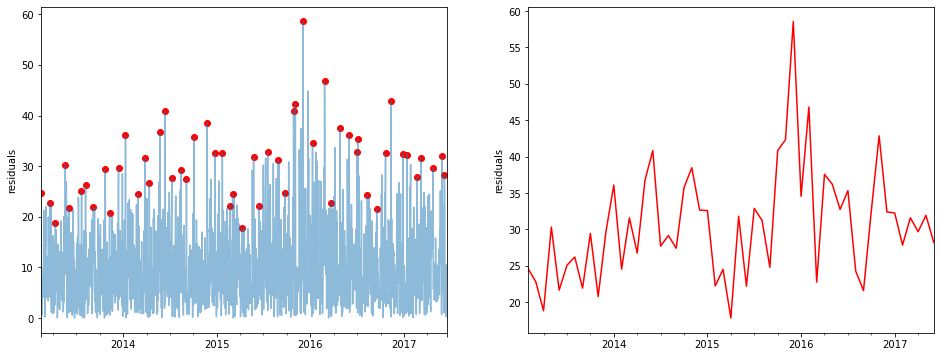

In [16]:
### PLOT BLOCK MAXIMA BLOCKS ###

plt.figure(figsize=(16,6))

plt.subplot(121)
data.plot(ax=plt.gca(), alpha=0.5)
plt.scatter(data[data.resample('1M').apply(lambda x: x.idxmax()).values].index, 
            data[data.resample('1M').apply(lambda x: x.idxmax()).values].values, c='red')
plt.ylabel('residuals')

plt.subplot(122)
data = data.resample('1M').max()
data.plot(ax=plt.gca(), c='red')
plt.ylabel('residuals')

The second step consists of modeling extreme values. We want to assign a distribution of reference where these values come from. According to the choice made before on how to select the anomalies/extremes, we have different candidates distribution from which choose. For our work, we select the Block Maxima Method with blocks of the length of 30 days. With this approach, we are confident in thinking that the extreme events are drawn from a Generalized Extreme Value (GEV) or Gumble distribution. The choice can be mathematically computed performing the maximum likelihood estimation, from which we select the best distribution with the best parameters.


In [17]:
### UTILITY FUNCTION FOR STATISTICS BOOTSTRAP ###

def bootstrap_ci(
    data, 
    statfunction=np.average, 
    alpha = 0.05, 
    n_samples = 100):

    """inspired by https://github.com/cgevans/scikits-bootstrap"""

    def bootstrap_ids(data, n_samples=100):
        for _ in range(n_samples):
            yield np.random.randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha/2, 1 - alpha/2])
    nvals = np.round((n_samples - 1) * alphas).astype(int)
    if np.any(nvals < 10) or np.any(nvals >= n_samples-10):
        warnings.warn("Some values used extremal samples; results are probably unstable. "
                      "Try to increase n_samples")

    data = np.array(data)
    if np.prod(data.shape) != max(data.shape):
        raise ValueError("Data must be 1D")
    data = data.ravel()
    
    boot_indexes = bootstrap_ids(data, n_samples)
    stat = np.asarray([statfunction(data[_ids]) for _ids in boot_indexes])
    stat.sort(axis=0)

    return stat[nvals]
### GET DISTRIBUTION FOR EXTREME RESIDUALS ###

f = Fitter(data, distributions=['genextreme','gumbel_r'], bins=20)
f.fit()

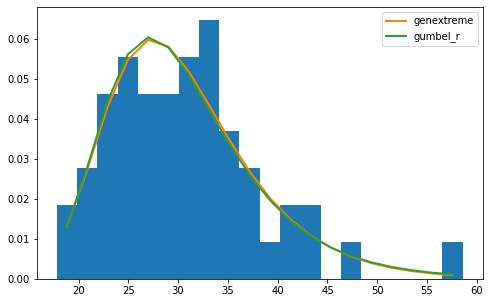

In [18]:
### PLOT DISTRIBUTION FOR EXTREME RESIDUALS ###

plt.figure(figsize=(8,5))

f.summary()
plt.grid(False)

In [19]:
best_dist = eval(f"stats.{list(f.get_best().keys())[0]}")
f.get_best()

{'genextreme': {'c': 0.029004237979821858,
  'loc': 27.23970226142145,
  'scale': 6.136443259882196}}

In [20]:
### RETRIVE ESTIMATED PARAMS FROM THE BEST DISTRIBUTION ###

best_params = best_dist.fit(data)
best_params

(0.029004237979821858, 27.23970226142145, 6.136443259882196)

In [21]:
### COMPUTE BOOTSTRAP INTERVALS FOR THE ESTIMATED BEST PARAMS ###

np.random.seed(111)
ci_params = bootstrap_ci(data, best_dist.fit, n_samples=500)
ci_params

array([[-0., 25.,  5.],
       [ 0., 30.,  7.]])

In [22]:
### DEFINE RETURN PERIODS AND ESTIMATED RETURN VALUES ###

eps = 1e-1
T = np.arange(1, 1000, eps) + eps # return periods
q = 1-1/T
ppf = best_dist.ppf(q, *best_params) # return values

In [23]:
### COMPUTE BOOTSTRAP INTERVALS FOR THE ESTIMATED RETURN VALUES ###

def gen_ppf(data, q):
    
    new_param = best_dist.fit(data)
    ppf = best_dist.ppf(q, *new_param)
    
    return ppf

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)
ci_ppf

array([[ 20.,  22.,  23., ...,  46.,  46.,  46.],
       [ 24.,  26.,  27., ..., 105., 105., 105.]])

With these pieces, we are ready to move the last step. We need only to select some time steps, technically called return periods, on which to calculate the relative return values. For each return period, we can expect to see at least one instance to exceed the estimated return values. Given t as a return period, an expected return value (E) means that for the next t*30 days we can expect to see some values exceeding E with a probability equal to 1/t. In our specific case of study, the returned values are the residuals that we may expect to exceed in the upcoming future, i.e. unexpected events that we can classify as anomalies.


In the plot below, we can show the modeled return values for the future together with the observed maxima observation of our validation set. The accompanying table summarizes more formally our findings. For example, the first row says that in the upcoming 30 days we can expect (with a relatively high probability) to have an observation that exceeds 21 absolute points the predictions of our model. In the same way, the last row says that we can expect (with a relatively low probability) to have an observation that exceeds 53 absolute points the predictions of our model in the following 3000 days. The confidence intervals are calculated using bootstrapped statistics.

Text(0.5, 0, 'return periods (log scale)')

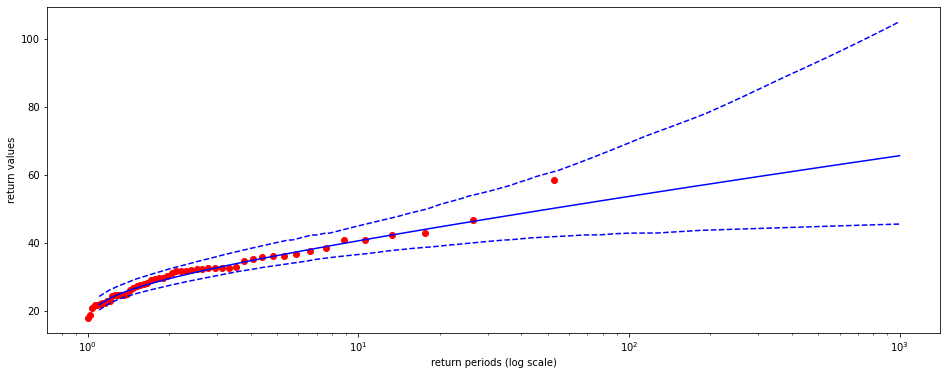

In [24]:
### RETURN VALUE PLOT ###

plt.figure(figsize=(16,6))

plt.semilogx(T, ppf, c='blue')
plt.semilogx(T, ci_ppf[0], c='blue', linestyle='--')
plt.semilogx(T, ci_ppf[1], c='blue', linestyle='--')

N = np.arange(1, len(data)+1)
plt.scatter(N[-1]/N, sorted(data)[::-1], color = 'red')
plt.ylabel('return values'); plt.xlabel('return periods (log scale)')

The explained procedure was applied to the residuals with the one-step-ahead forecasts but the same can be computed with other forecasting horizons.

In [25]:
### CREATE A SHORT SUMMARY ###

eps = 1e-1
T = np.asarray([1, 2, 5, 10, 25, 50, 100]) + eps
q = 1-1/T
ppf = best_dist.ppf(q, *best_params)

np.random.seed(111)
ci_ppf = bootstrap_ci(data, lambda x: gen_ppf(x, q), n_samples=500, alpha=0.05)

summary = pd.DataFrame({
    'return_period':(T-eps).astype(int),
    'low_ci':ci_ppf[0], 
    'return_value':ppf, 
    'up_ci':ci_ppf[-1]
}).set_index('return_period')

summary

,low_ci,return_value,up_ci
return_period,,,
1,20.233322,21.804172,24.222277
2,27.835475,29.898257,32.779884
5,33.446162,36.376796,40.255135
10,36.612441,40.668232,45.075656
25,39.820802,46.007188,53.561416
50,41.734564,49.889580,60.447740
100,42.860320,53.671503,69.420075
